Based on the tutorial from https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/brain3k/1-Processing-and-Integration.html

In [1]:
import mudatasets as mds

In [9]:
import scipy.io
import pandas as pd
import numpy as np
from anndata import AnnData
from mudata import MuData
import scanpy as sc
import muon as mu
from muon import atac as ac
from os.path import join
from vitessce.data_utils import (
    VAR_CHUNK_SIZE,
    optimize_adata,
)

## Load the data

In [3]:
mdata = mds.load("brain3k_multiome", full=True)
mdata.var_names_make_unique()
mdata

■ File filtered_feature_bc_matrix.h5 from brain3k_multiome has been found at /Users/mkeller/mudatasets/brain3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from brain3k_multiome has been found at /Users/mkeller/mudatasets/brain3k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from brain3k_multiome has been found at /Users/mkeller/mudatasets/brain3k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from brain3k_multiome has been found at /Users/mkeller/mudatasets/brain3k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from brain3k_multiome has been found at /Users/mkeller/mudatasets/brain3k_multiome/atac_peak_annotation.tsv
■ Checksum is validated (md5) for atac_peak_annotation.tsv
■ Loading filtered_feature

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/mkeller/mudatasets/brain3k_multiome/filtered_feature_bc_matrix.h5


/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /Users/mkeller/mudatasets/brain3k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /Users/mkeller/mudatasets/brain3k_multiome/atac_fragments.tsv.gz


MuData object with n_obs × n_vars = 3233 × 170631
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	3233 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	3233 x 134030
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

## 1. RNA

## QC

In [4]:
# `rna` will point to `mdata['rna']`
# unless we copy it
rna = mdata['rna']

In [5]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

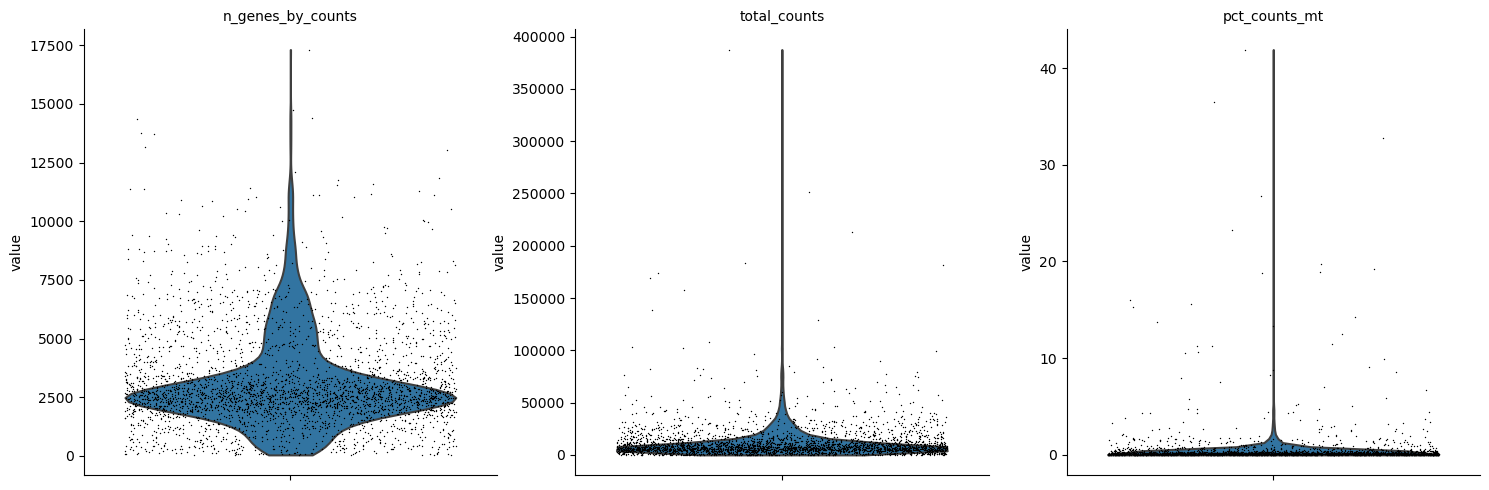

In [6]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [7]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 8000))
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 2)

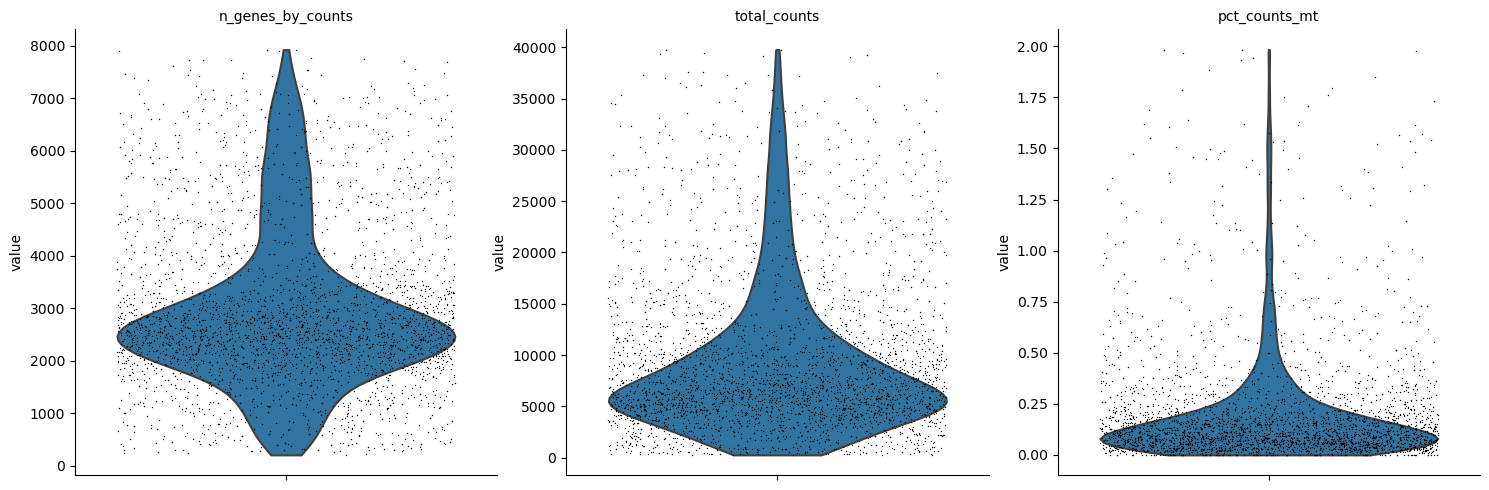

In [8]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

## Scaling and normalization

In [10]:
rna.layers["counts"] = rna.X.copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
# rna.raw = rna
rna.layers["lognorm"] = rna.X.copy()

## Identify highly-variable genes

In [11]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

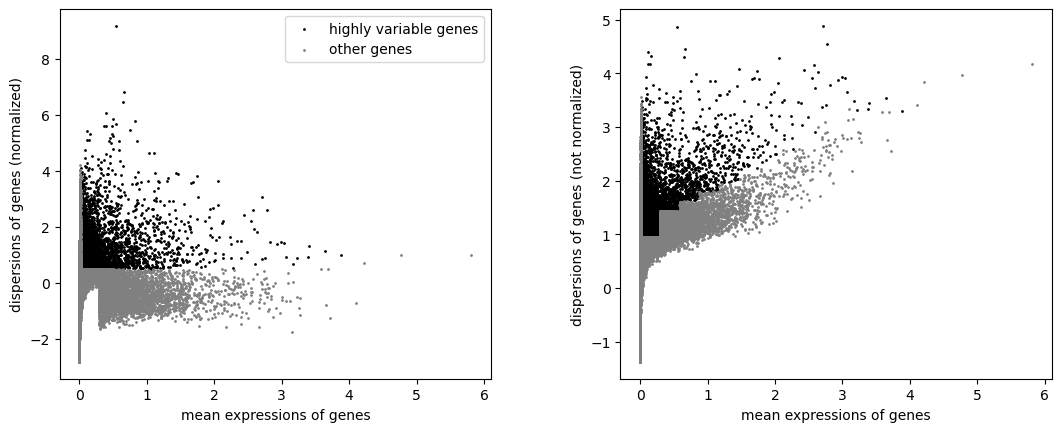

In [12]:
sc.pl.highly_variable_genes(rna)

In [13]:
sc.pp.scale(rna, max_value=10)

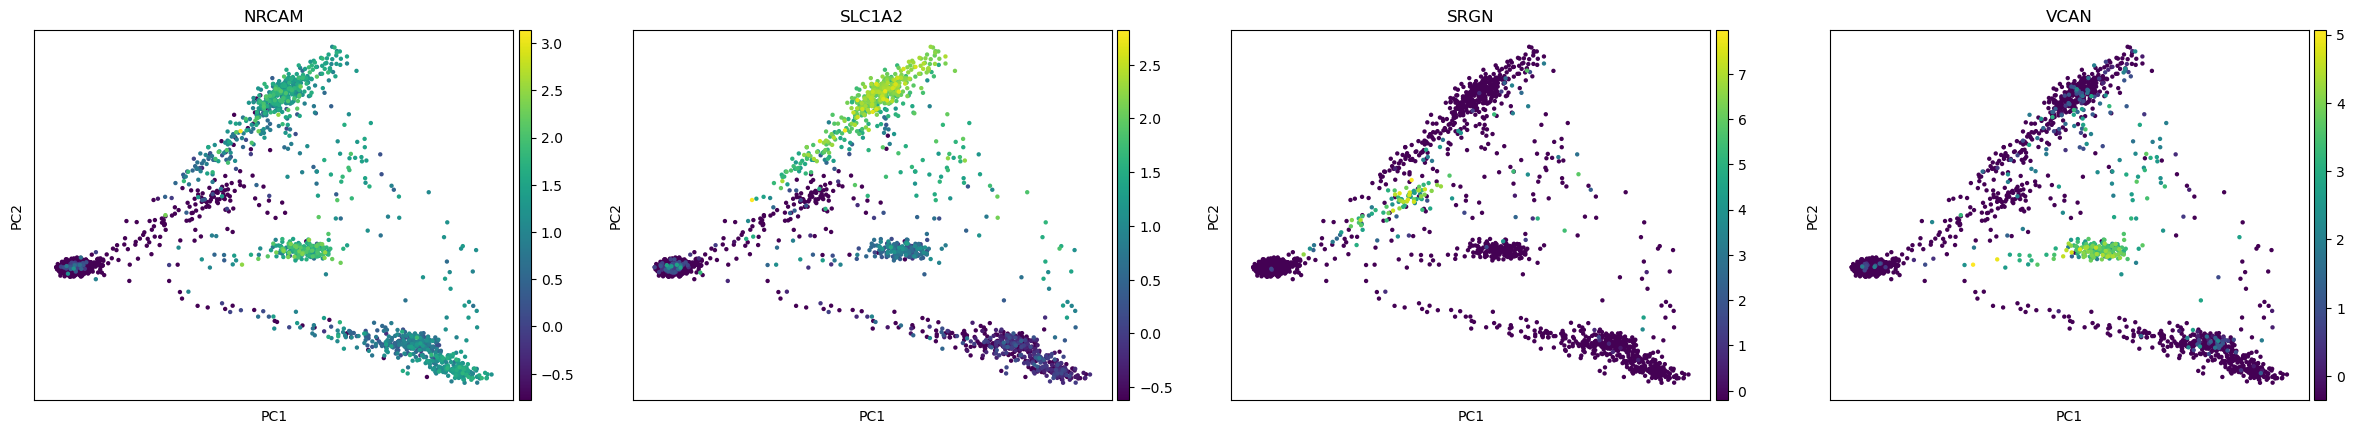

In [14]:
sc.tl.pca(rna, svd_solver='arpack')
sc.pl.pca(rna, color=['NRCAM', 'SLC1A2', 'SRGN', 'VCAN'])

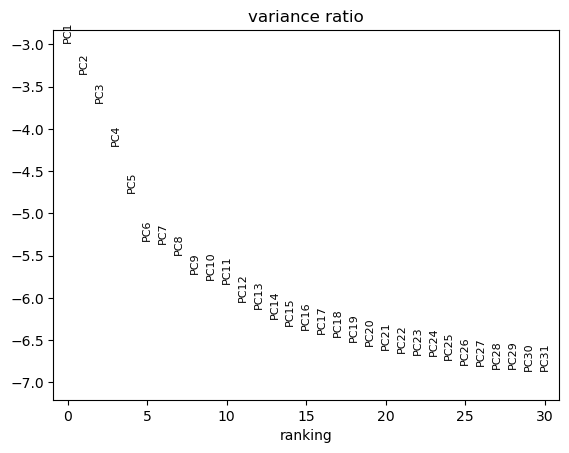

In [15]:
sc.pl.pca_variance_ratio(rna, log=True)

In [16]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.5)

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


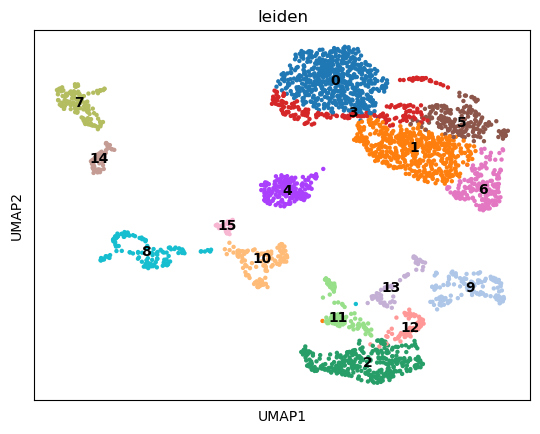

In [17]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="leiden", legend_loc="on data")

## Cell type annotation

In [18]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes

In [19]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p
0,PLP1,0.000000e+00,CTNNA3,0.000000e+00,SLC1A2,0.000000e+00,CTNNA3,1.386847e-229,PCDH15,2.652644e-260,CTNNA3,3.905330e-260,MALAT1,7.906135e-50,KCNIP4,0.000000e+00,DLGAP1,8.963566e-194,LRMDA,6.608572e-69,SNHG14,1.318458e-152,GPC5,4.747626e-143,GPC5,5.962442e-98,PITPNC1,9.111519e-22,SYT1,2.014135e-63,GRIP1,3.853040e-36
1,CNP,0.000000e+00,ST18,3.592953e-291,GPC5,0.000000e+00,MBP,1.444126e-192,DSCAM,2.336696e-305,ST18,2.585290e-194,CTNNA3,1.591178e-39,RBFOX1,0.000000e+00,RBFOX1,2.306675e-165,CD83,4.238996e-53,MYT1L,4.228744e-112,GPM6A,6.184337e-127,ADGRV1,5.959753e-80,SORBS1,2.769325e-21,RIMS2,1.193609e-67,KAZN,1.975049e-45
2,CRYAB,5.818068e-309,IL1RAPL1,2.070259e-294,GPM6A,0.000000e+00,ST18,1.875072e-177,OPCML,0.000000e+00,RNF220,1.075643e-143,HSP90AA1,4.793518e-36,HS6ST3,1.256068e-204,SNHG14,1.267656e-150,ST6GAL1,6.552671e-52,ADARB2,2.600669e-107,SLC1A2,4.501662e-99,CTNNA2,1.628352e-100,ATP1B3,1.189084e-20,RALYL,5.803705e-50,CCSER1,5.615775e-40
3,PTGDS,0.000000e+00,SLC44A1,4.986927e-285,ADGRV1,0.000000e+00,PLP1,1.279525e-126,PTPRZ1,2.238103e-246,DPYD,1.199296e-129,DST,6.047507e-33,CSMD1,0.000000e+00,SYT1,8.597039e-104,SRGAP2,8.299153e-52,KAZN,1.972062e-117,CTNNA2,1.565429e-127,SLC1A2,3.758757e-74,MSI2,2.379704e-20,CSMD1,4.780335e-68,RBFOX1,7.619173e-44
4,DBNDD2,1.037651e-239,PIP4K2A,2.163150e-281,RYR3,2.466260e-295,SLC44A1,3.475296e-155,LHFPL3,2.683399e-174,SLC44A1,7.520263e-175,SLC24A2,3.026886e-23,MEG3,4.656631e-203,PCLO,7.207201e-97,SFMBT2,4.823747e-52,CCSER1,2.340052e-97,SOX5,5.678717e-104,GPM6A,8.016944e-74,MALAT1,6.752891e-19,KALRN,3.398583e-57,RGS7,1.476733e-37
5,MBP,0.000000e+00,DOCK10,2.287142e-277,PITPNC1,0.000000e+00,TMEM144,1.050397e-118,TNR,2.855693e-170,MBP,2.024457e-152,CCDC88A,1.073638e-19,LRRTM4,4.263504e-303,ATRNL1,6.402239e-104,MEF2C,2.862382e-52,FGF14,5.598255e-104,ADGRV1,8.510522e-89,NRG3,4.988985e-98,ZNF331,5.170967e-18,FAM155A,5.268105e-71,ATP8A2,4.490743e-32
6,FTH1,3.202172e-278,RNF220,4.146057e-258,CTNNA2,0.000000e+00,ENPP2,7.824210e-113,LUZP2,1.352114e-163,IL1RAPL1,7.412117e-161,RNF220,5.682518e-20,CHRM3,9.130756e-163,NRG3,6.918291e-163,PLXDC2,1.746137e-53,CHRM3,2.419674e-85,DTNA,6.489832e-107,NRXN1,9.405196e-92,NR4A3,3.365677e-15,NRG3,1.653593e-76,SYT1,5.838566e-34
7,APLP1,1.587117e-243,SIK3,7.518543e-250,LSAMP,0.000000e+00,DPYD,6.395354e-108,KCNIP4,0.000000e+00,NKAIN2,8.749897e-112,IL1RAPL1,6.968710e-21,PHACTR1,1.999672e-227,RIMS2,1.884141e-98,CHST11,5.488205e-50,MEG3,5.315741e-91,NKAIN3,4.128601e-84,SOX5,3.825931e-70,ESYT2,6.388757e-15,LDB2,9.921844e-48,FGF13,4.472785e-28
8,QDPR,1.078225e-240,ELMO1,1.426415e-265,NRXN1,0.000000e+00,MOBP,6.776681e-100,LRRC4C,2.475997e-240,SLC24A2,1.448726e-128,ST18,8.850388e-16,KALRN,2.925946e-186,GRIP1,2.286657e-86,ITPR2,1.985314e-51,GALNTL6,3.329208e-80,NRXN1,7.657986e-115,NTM,3.138094e-90,NR4A2,1.847265e-14,DLGAP2,2.893882e-49,MTUS2,6.490847e-31
9,RNASE1,2.269335e-200,SLC24A2,6.296726e-260,SOX5,0.000000e+00,TMEM165,5.230857e-108,CSMD1,9.004584e-279,PIP4K2A,9.856688e-124,POLR2F,2.904285e-15,SYT1,4.039716e-199,KAZN,8.369727e-100,FRMD4A,4.761944e-51,FRMD4A,1.877699e-95,LINC00299,2.855548e-75,RYR3,3.475680e-60,TLE1,1.991057e-14,GABRB2,3.786100e-50,DAB1,1.382530e-34


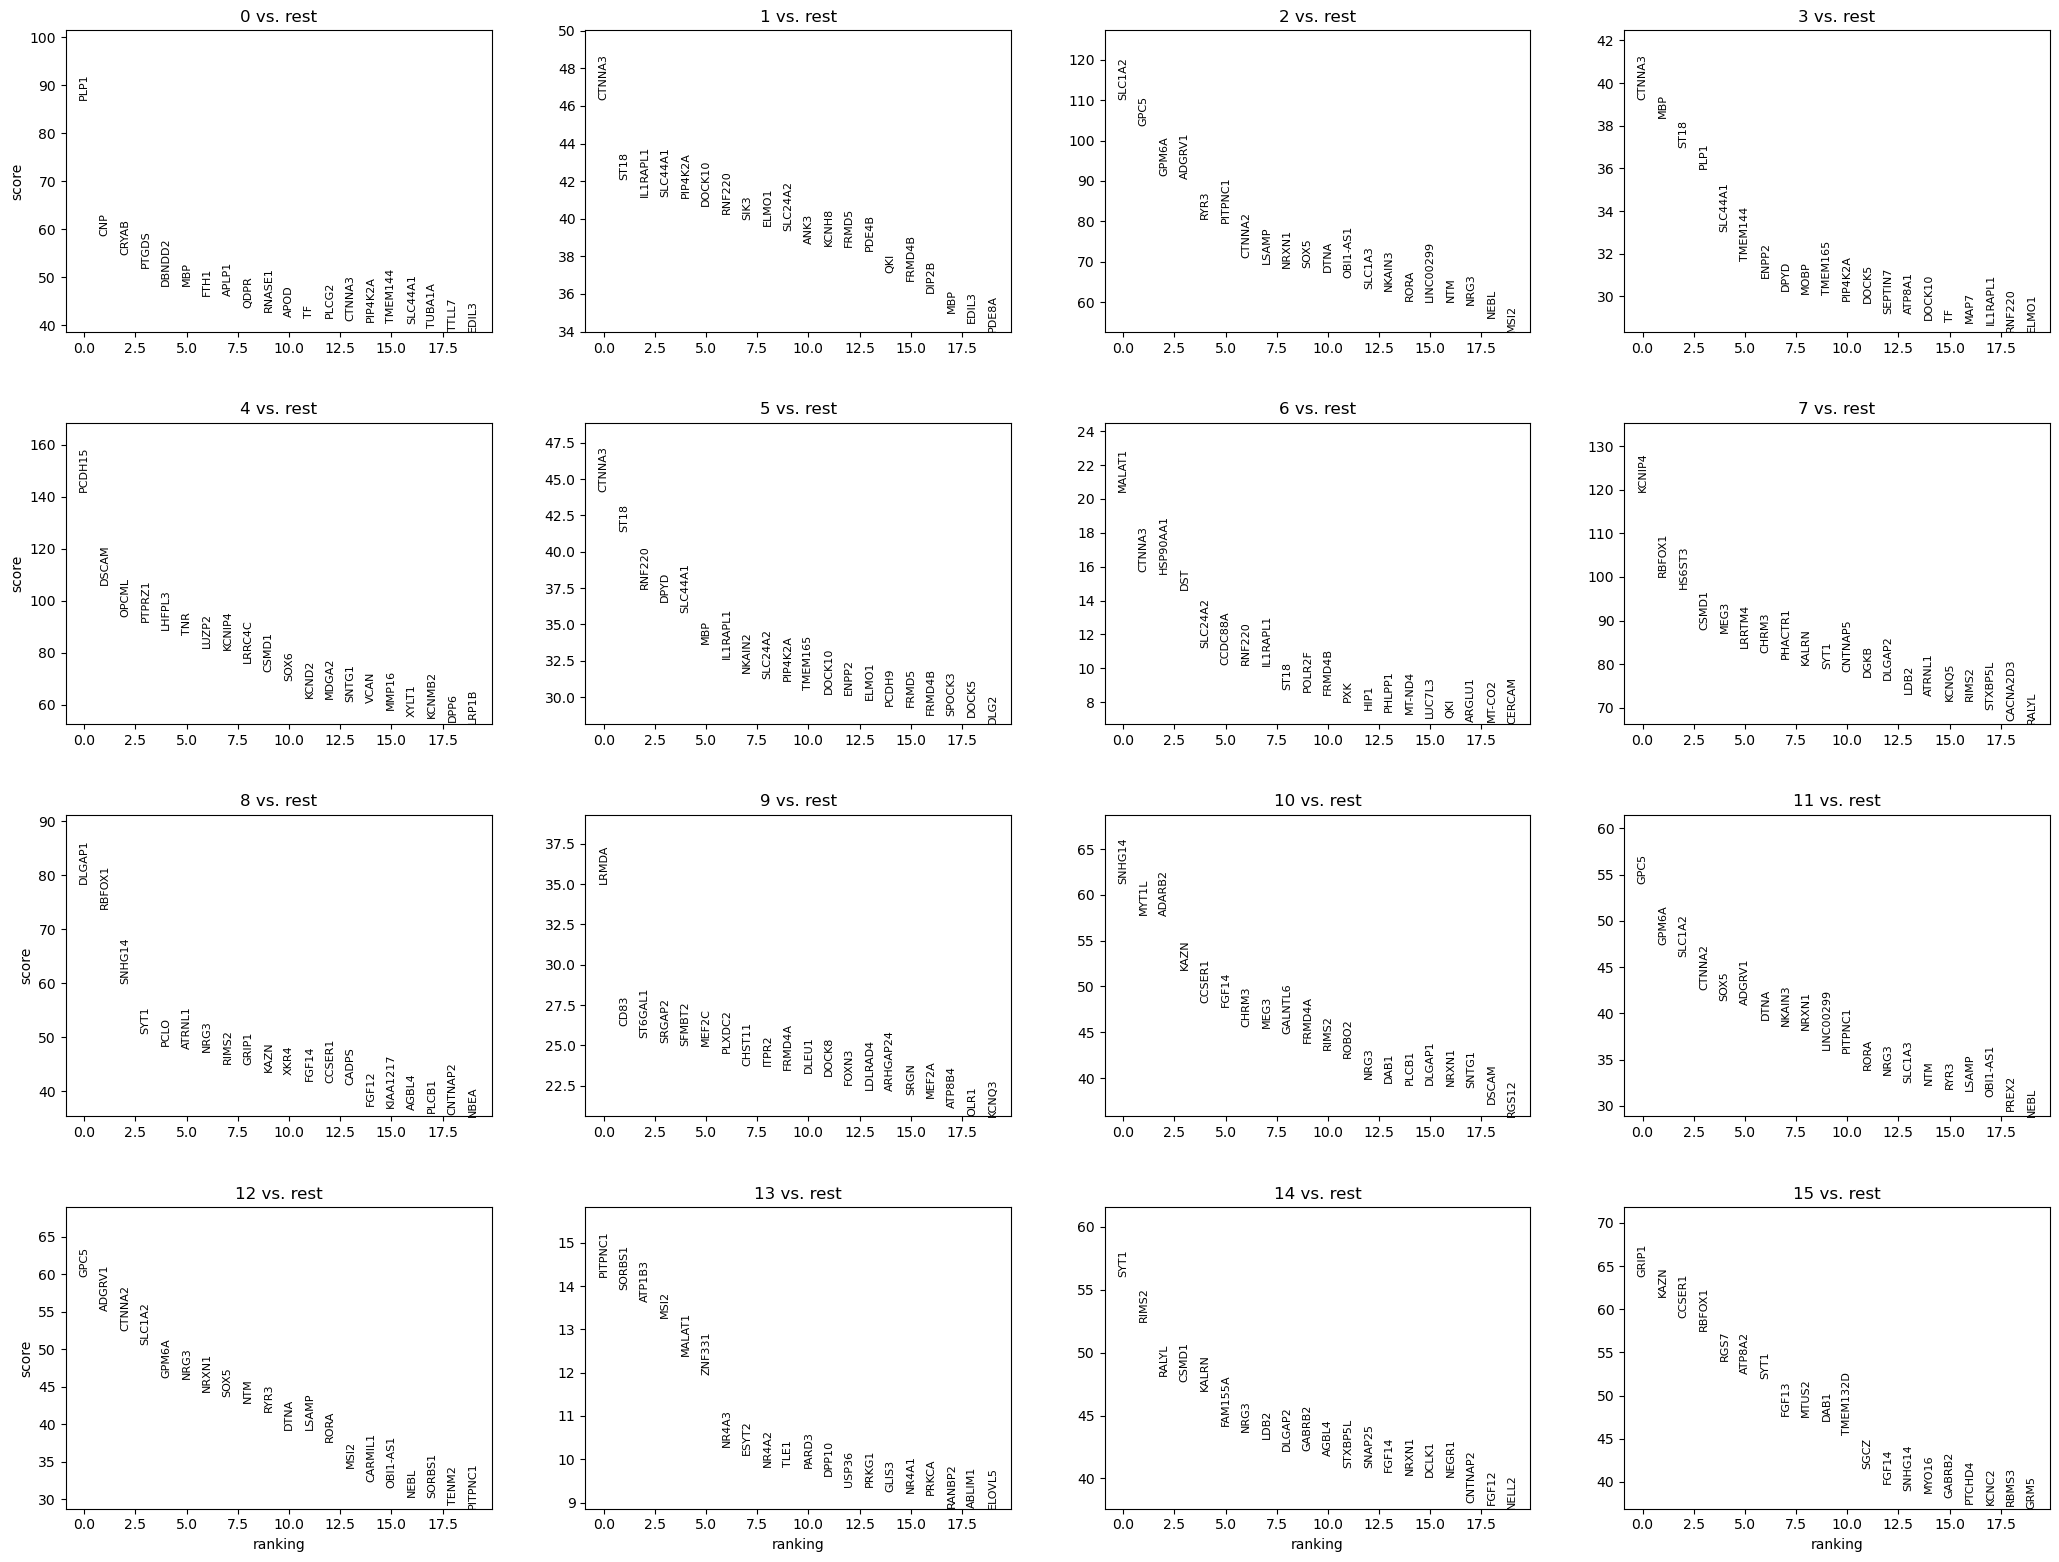

In [20]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

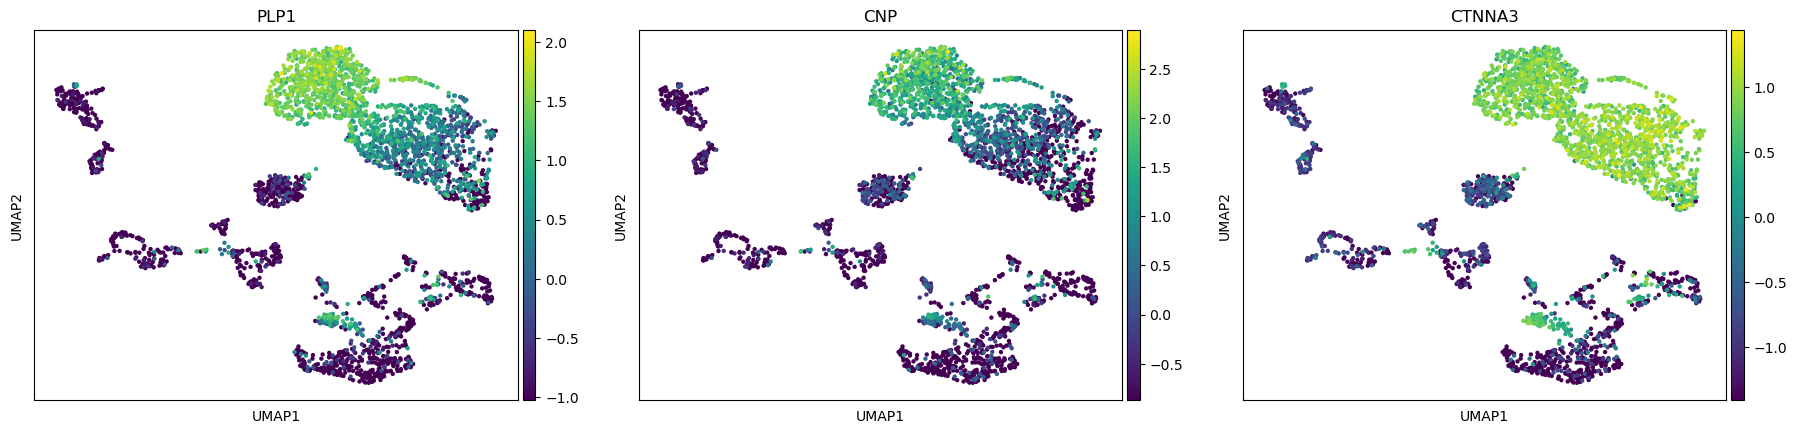

In [21]:
sc.pl.umap(rna, color=["PLP1", "CNP", "CTNNA3"])

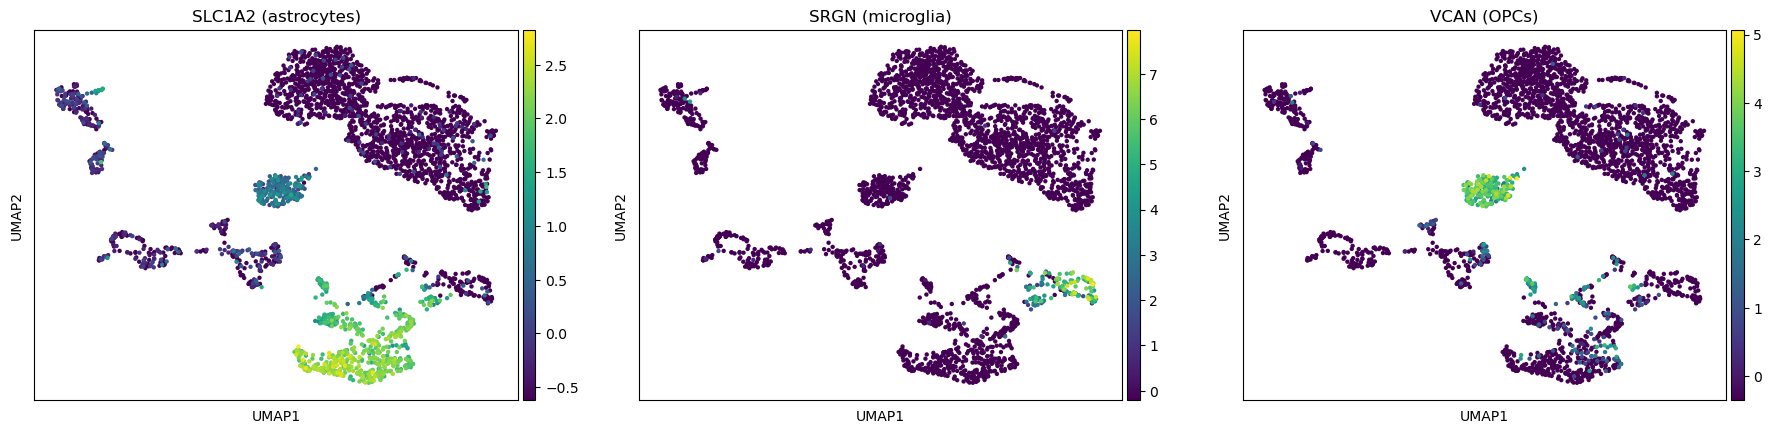

In [22]:
sc.pl.umap(rna, color=["SLC1A2", "SRGN", "VCAN"], title=["SLC1A2 (astrocytes)", "SRGN (microglia)", "VCAN (OPCs)"])

In [23]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "oligodendrocyte",
    "5": "oligodendrocyte",
    "14": "oligodendrocyte",
    "4": "OPC",
    "8": "microglia",
    "2": "astrocyte",
    "10": "astrocyte",
    "11": "astrocyte",
    "12": "astrocyte",
    "6": "excitatory_LAMP5",
    "13": "excitatory_RORB",
    "7": "inhibitory_LHX6",
    "9": "inhibitory_ADARB2",
    "15": "inhibitory_ADARB2",
}

In [24]:
rna.obs['celltype'] = [new_cluster_names[cl] for cl in rna.obs.leiden.astype("str").values]
rna.obs.celltype = rna.obs.celltype.astype("category")

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


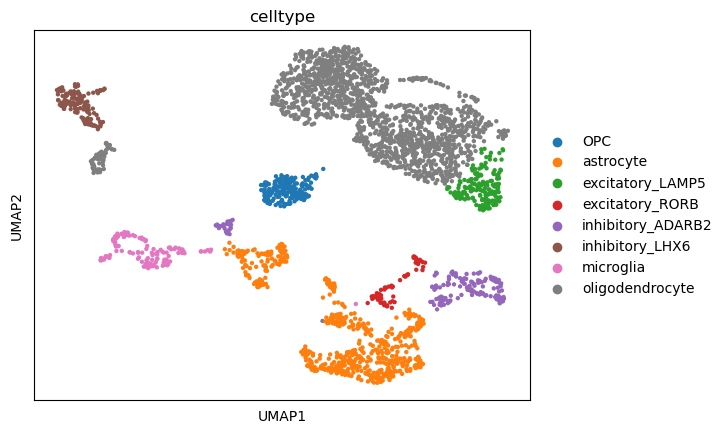

In [25]:
sc.pl.umap(rna, color="celltype")

## 2. ATAC

In [26]:
atac = mdata.mod['atac']

In [27]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

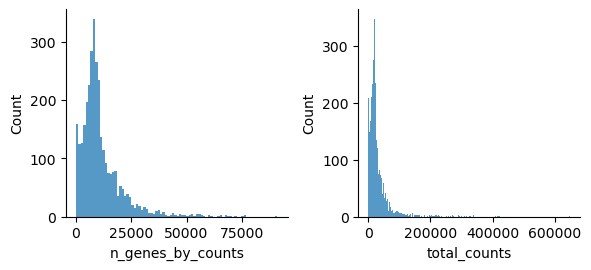

In [28]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

In [29]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [30]:
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))

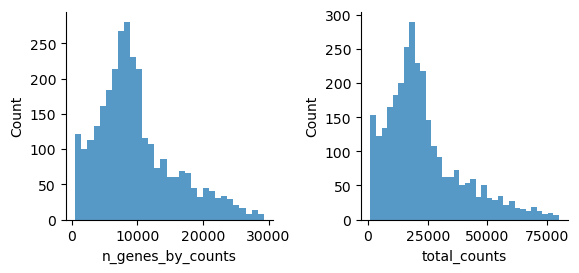

In [31]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

Fetching Regions...: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


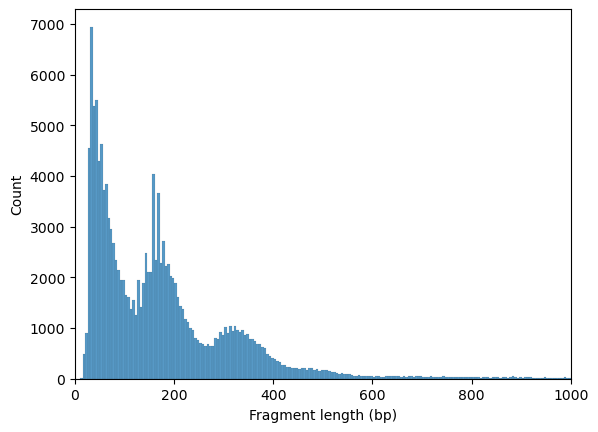

In [32]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [33]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|███████████████████████████████████████| 1000000/1000000 [00:03<00:00, 320728.49it/s]


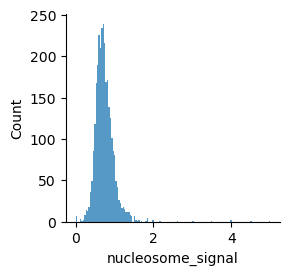

In [34]:
mu.pl.histogram(atac, "nucleosome_signal", linewidth=0)

In [35]:
# Check TSS enrichment
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
MIR1302-2HG,chr1,29553,30267,ENSG00000243485,MIR1302-2HG
FAM138A,chr1,36080,36081,ENSG00000237613,FAM138A
OR4F5,chr1,65418,69055,ENSG00000186092,OR4F5


In [36]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|██████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.26it/s]


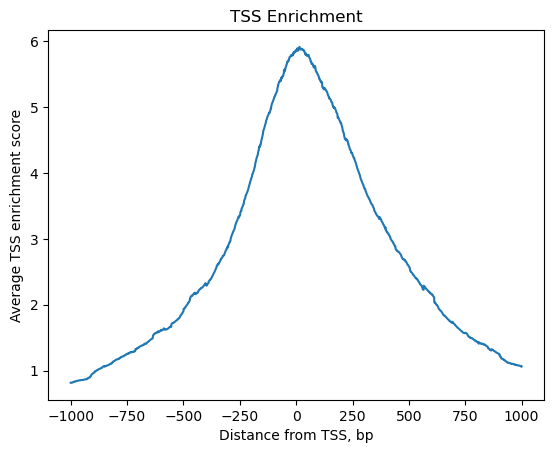

In [37]:
ac.pl.tss_enrichment(tss)

In [38]:
atac.layers["counts"] = atac.X.copy()
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers["lognorm"] = atac.X.copy()

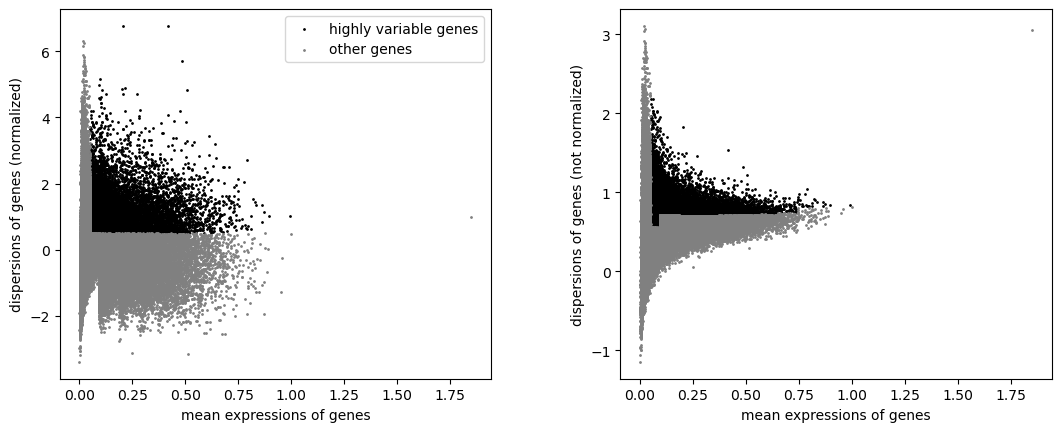

In [39]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [40]:
np.sum(atac.var.highly_variable)

13877

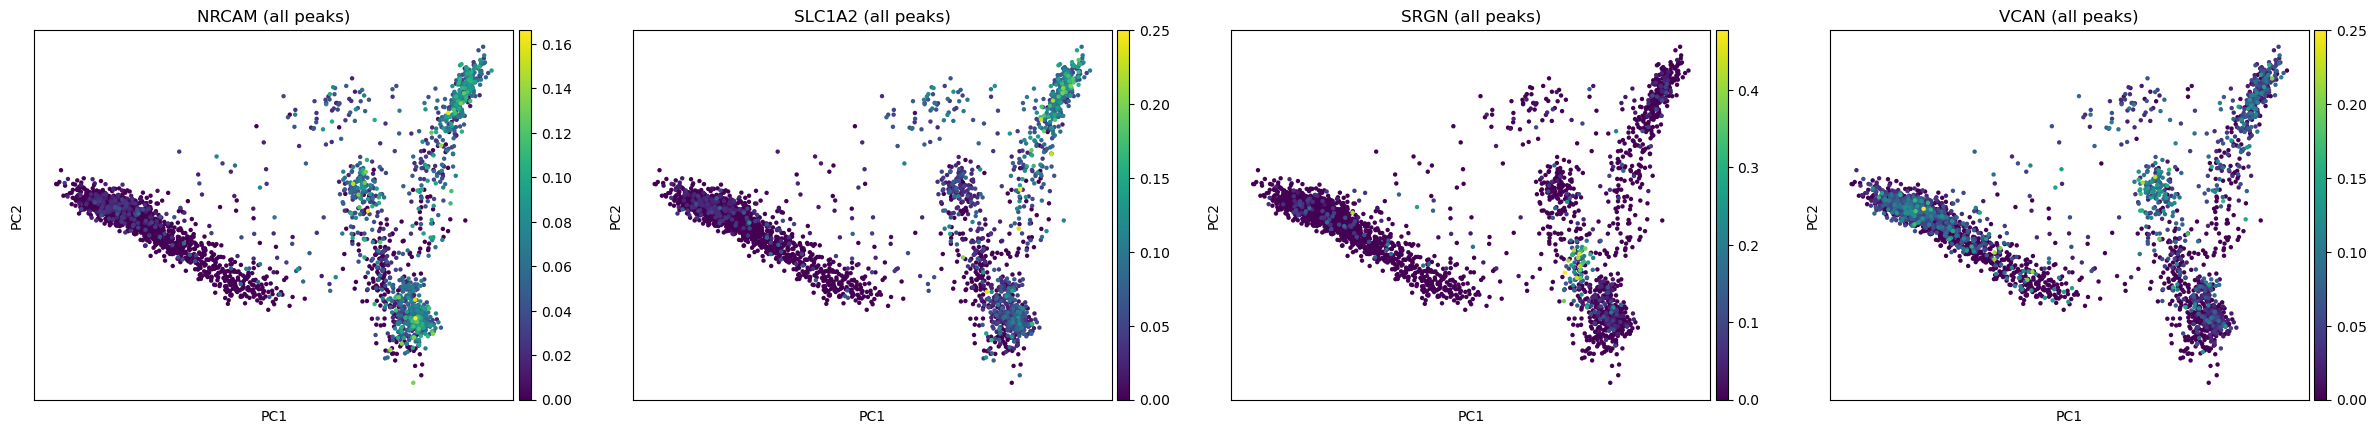

In [41]:
sc.pp.scale(atac, max_value=10)
sc.tl.pca(atac, svd_solver='arpack')
ac.pl.pca(atac, color=['NRCAM', 'SLC1A2', 'SRGN', 'VCAN'], layer='lognorm', func='mean')

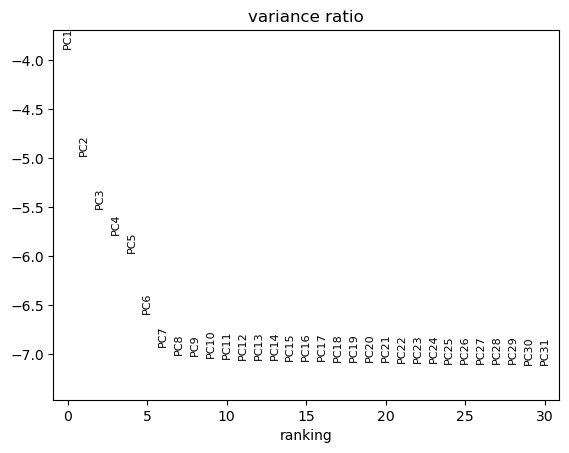

In [42]:
sc.pl.pca_variance_ratio(atac, log=True)

In [43]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)
sc.tl.leiden(atac, resolution=.5)

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


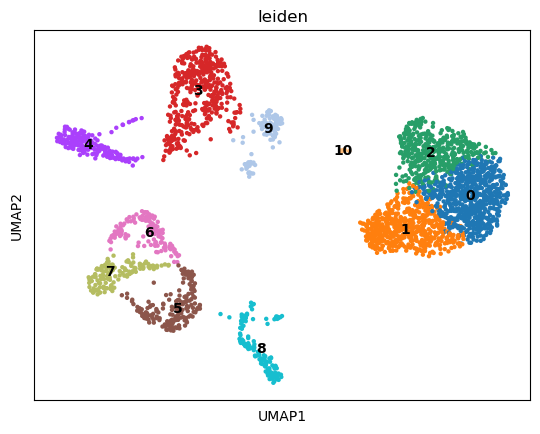

In [44]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(atac, color="leiden", legend_loc="on data")

## Marker genes and cell types

In [45]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes

In [46]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

try:
    pd.set_option("max_columns", 50)
except:
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
    pd.set_option("display.max_columns", 50)

pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,3_g,3_p,4_n,4_g,4_p,5_n,5_g,5_p,6_n,6_g,6_p,7_n,7_g,7_p,8_n,8_g,8_p,9_n,9_g,9_p,10_n,10_g,10_p
0,chr19:10517127-10518023,S1PR5,6.443265e-65,chr2:155733016-155733956,,5.625729e-07,chr14:19800463-19801343,OR4N2,3.472922e-35,chr15:88954455-88955355,MFGE8,1.909158e-53,chr20:64205357-64206289,MYT1,2.161747e-24,chr3:93470143-93471053,,7.728457e-64,chr2:172102411-172103256,"DLX2, DLX2-DT",2.862112e-17,chr3:93470143-93471053,,2.567446e-32,chr8:141128016-141128911,"DENND3, AC040970.1",2.511727e-16,chr3:93470143-93471053,,3.029055e-10,chr5:5421992-5422922,"ICE1, AC091978.1",5.036902e-08
1,chr9:137025205-137026128,"ABCA2, C9orf139",1.843640e-62,chr9:137194149-137195061,"SSNA1, TPRN",1.469448e-06,chr9:137021806-137022721,"C9orf139, ABCA2",5.046500e-28,chr11:116113975-116114894,LINC02703,4.379307e-49,chr1:235649644-235650468,GNG4,1.018436e-19,chr19:17830561-17831448,"JAK3, INSL3",1.501875e-26,chr19:17830561-17831448,"JAK3, INSL3",1.785222e-13,chr7:98869781-98870591,TMEM130,4.952732e-17,chr19:16324216-16325125,KLF2,1.639932e-15,chr14:93926839-93927741,"FAM181A, FAM181A-AS1",1.142541e-09,chr3:150762879-150763765,"SIAH2, SIAH2-AS1",3.660542e-05
2,chr17:4533823-4534672,"MYBBP1A, SPNS2",1.025702e-58,chr11:67410019-67410923,"CARNS1, TBC1D10C",1.680959e-06,chr20:48656406-48657246,"AL035106.1, PREX1",2.362718e-27,chr17:7667553-7668441,TP53,4.965136e-47,chr7:159144522-159145447,VIPR2,1.325963e-19,chr22:20424868-20425672,SCARF2,1.767269e-23,chr11:43580653-43581568,"MIR670HG, AC068205.1",2.103368e-13,chr6:34465545-34466455,PACSIN1,5.421674e-16,chr19:16896819-16897691,"F2RL3, CPAMD8",1.884857e-14,chr5:90558277-90559161,ADGRV1,1.415188e-09,chr9:4740847-4741719,AK3,1.084190e-05
3,chr16:1046313-1047208,AC009041.3,4.414004e-57,chr1:26555262-26556177,RPS6KA1,2.240104e-06,chr11:61760795-61761661,"MYRF, MYRF-AS1",7.380426e-27,chr2:63050200-63051132,OTX1,7.300666e-46,chr10:115092748-115093673,ATRNL1,1.429046e-19,chr3:6860613-6861507,GRM7,1.402679e-23,chr1:159141445-159142305,CADM3,6.791239e-13,chr20:38723830-38724734,SLC32A1,5.596753e-16,chr19:6730124-6731045,GPR108,3.679240e-14,chr7:153523847-153524661,LINC01287,2.492949e-09,chr6:41712509-41713277,"TFEB, AL035588.1",3.375334e-05
4,chr5:669160-670066,"TPPP, AC026740.1",6.411012e-56,chr22:27641917-27642832,AL121885.3,2.989680e-06,chr7:914026-914890,ADAP1,6.522413e-26,chr3:93470143-93471053,,6.416216e-48,chr22:37412328-37413244,ELFN2,1.669758e-19,chr3:11136760-11137765,HRH1,1.013443e-22,chr20:63501902-63502698,AL121829.1,7.636812e-13,chr2:172084895-172085680,DLX1,4.264626e-15,chr5:40679337-40680186,"PTGER4, TTC33",9.874328e-14,chr1:19643792-19644718,NBL1,2.635539e-09,chr5:68187291-68188210,LINC02219,8.983458e-05
5,chr1:25563471-25564360,"LDLRAP1, AL606491.1",1.309855e-48,chr2:16069783-16070654,GACAT3,3.525907e-06,chr9:136978081-136978957,PTGDS,8.803369e-26,chr10:117551948-117552792,EMX2OS,2.072447e-44,chr1:103108243-103109114,COL11A1,3.066915e-19,chr2:96148230-96149146,AC012307.1,1.741706e-21,chr20:38723830-38724734,SLC32A1,1.403797e-12,chr22:43862092-43862988,SULT4A1,8.645234e-15,chr2:8583428-8584334,LINC01814,1.619466e-13,chr12:126742073-126742937,"LINC00943, LINC00944",3.324658e-09,chr17:60599687-60600583,PPM1D,1.355020e-04
6,chr16:19005407-19006339,TMC7,1.804298e-46,chr7:28408777-28409685,CREB5,9.937127e-06,chr19:10517127-10518023,S1PR5,1.647228e-25,chr1:59986377-59987289,CYP2J2,3.596186e-44,chr14:28766242-28767112,FOXG1,1.565355e-18,chr19:42352133-42353032,MEGF8,8.060144e-21,chr10:133336493-133337402,CALY,2.029217e-12,chr2:172102411-172103256,"DLX2, DLX2-DT",1.678817e-14,chr19:48492859-48493838,LMTK3,7.564888e-13,chr22:44668148-44669084,PRR5,4.183188e-09,chr2:241355778-241356651,FARP2,1.397696e-04
7,chr19:29504722-29505572,"AC011474.2, AC011474.1",1.796737e-45,chr19:18097259-18098167,"MAST3, IL12RB1",9.990585e-06,chr16:19005407-19006339,TMC7,3.457424e-25,chr4:7244199-7245095,SORCS2,7.491149e-44,chr3:119329382-119330238,"ARHGAP31-AS1, ARHGAP31",2.371422e-18,chr7:4540

In [47]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["9"]))

In [48]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "OPC",
    "7": "microglia",
    "2": "astrocyte",
    "8": "astrocyte",
    "4": "excitatory",
    "5": "inhibitory1",
    "6": "inhibitory2",
    "10": "unk"
}

In [49]:
atac.obs['celltype'] = [new_cluster_names[cl] for cl in atac.obs.leiden.astype("str").values]
atac.obs.celltype = atac.obs.celltype.astype("category")

/Users/mkeller/anaconda3/envs/vitessce-tutorial-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


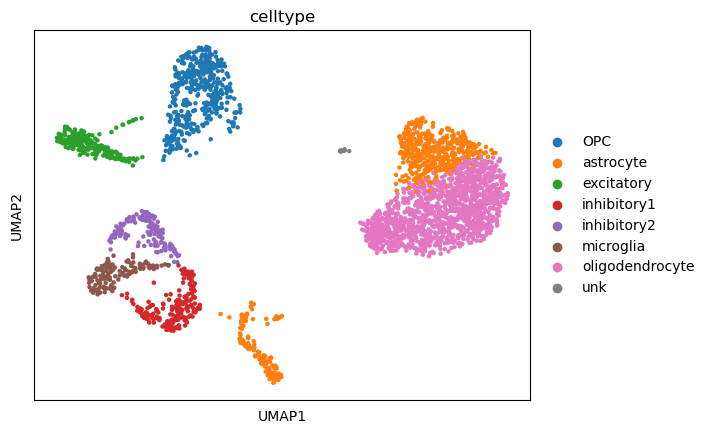

In [50]:
sc.pl.umap(atac, color="celltype")

## 3. Multi-omics integration
Discard cells that are not in both modalities.

In [51]:
mdata.update()

In [52]:
mu.pp.intersect_obs(mdata)

In [53]:
mu.tl.mofa(mdata, n_factors=20, outfile="brain3k_mofa_model.hdf5", gpu_mode=True)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=2747 samples and D=5924 features...
Loaded view='atac' group='group1' with N=2747 samples and D=13877 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: 

In [54]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

In [55]:
mdata.obsm["X_mofa_umap"] = mdata.obsm["X_umap"]

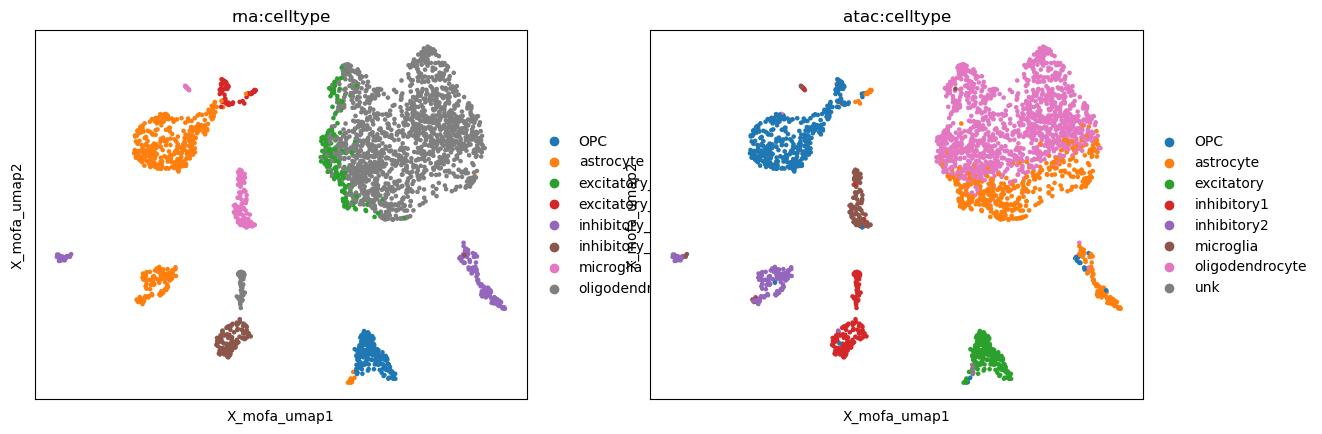

In [56]:
mu.pl.embedding(mdata, basis="X_mofa_umap", color=["rna:celltype", "atac:celltype"])

In [57]:
# Reference: https://github.com/scverse/muon/issues/65
mdata.mod["atac"].uns = {}
mdata.mod["rna"].uns = {}
mdata.uns = {}

In [75]:
rna.var.gene_ids = rna.var.gene_ids.astype("str")
atac.var.gene_ids = atac.var.gene_ids.astype("str")

In [79]:
atac.obsm["X_hvg"] = atac[:, atac.var["highly_variable"]].copy().X
rna.obsm["X_hvg"] = rna[:, rna.var["highly_variable"]].copy().X

In [80]:
mdata.mod["atac"] = optimize_adata(
    atac,
    obs_cols=["leiden", "celltype"],
    obsm_keys=["X_pca", "X_umap", "X_hvg"],
    var_cols=["gene_ids", "feature_types", "genome", "interval", "highly_variable"],
    layer_keys=["counts", "lognorm"]
)
mdata.mod["rna"] = optimize_adata(
    rna,
    obs_cols=["leiden", "celltype"],
    obsm_keys=["X_pca", "X_umap", "X_hvg"],
    var_cols=["gene_ids", "feature_types", "genome", "interval", "highly_variable"],
    layer_keys=["counts", "lognorm"]
)

In [89]:
# Fix issue during writing to zarr - this column contains bool and NaN
mdata.var["rna:mt"] = mdata.var["rna:mt"].astype(str)

In [91]:
# TODO: sort var axis by genome (ATAC) and hierarchical clustering (RNA)

In [88]:
mdata

MuData object with n_obs × n_vars = 2747 × 170629
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  obsm:	'X_mofa', 'X_umap', 'X_mofa_umap'
  varm:	'LFs'
  obsp:	'distances', 'connectivities'
  2 modalities
    rna:	2747 x 36601
      obs:	'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable'
      obsm:	'X_pca', 'X_umap', 'X_hvg'
      varm:	'PCs'
      layers:	'counts', 'lognorm'
    atac:	2747 x 134028
      obs:	'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable'
      obsm:	'X_pca', 'X_umap', 'X_hvg'
      varm:	'PCs'
      layers:	'counts', 'lognorm'

In [87]:
mdata.write_zarr("data/brain3k_processed.mdata.zarr")

## Configure visualization

In [92]:
from vitessce import (
    VitessceConfig,
    ViewType as vt,
    CoordinationType as ct,
    FileType as ft,
    AnnDataWrapper,
    OmeTiffWrapper,
)

In [100]:
vc = VitessceConfig(schema_version="1.0.15", name='Multiome data', description='RNA+ATAC')

In [101]:
rna_zarr = join("data", "brain3k_processed.mdata.zarr", "mod", "rna")
atac_zarr = join("data", "brain3k_processed.mdata.zarr", "mod", "atac")
joint_zarr = join("data", "brain3k_processed.mdata.zarr")

In [102]:
dataset = vc.add_dataset(name='RNA+ATAC').add_object(AnnDataWrapper(
    # We run add_object with adata_path=rna_zarr first to add the cell-by-gene matrix and associated metadata.
    adata_path=rna_zarr,
    obs_embedding_paths=["obsm/X_umap"],
    obs_embedding_names=["UMAP"],
    obs_set_paths=["obs/celltype"],
    obs_set_names=["Cell Type"],
    obs_feature_matrix_path="obsm/X_hvg",
    feature_filter_path="var/highly_variable",
    # To be explicit that the features represent genes and gene expression, we specify that here.
    coordination_values={
        "featureType": "gene",
        "featureValueType": "expression"
    }
)).add_object(AnnDataWrapper(
    # We next run add_object with adata_path=adt_zarr to add the cell-by-ADT matrix and associated metadata.
    adata_path=atac_zarr,
    obs_embedding_paths=["obsm/X_umap"],
    obs_embedding_names=["UMAP"],
    obs_set_paths=["obs/celltype"],
    obs_set_names=["Cell Type"],
    obs_feature_matrix_path="obsm/X_hvg",
    feature_filter_path="var/highly_variable",
    # If the features do not represent genes and gene expression, we specify alternate values here.
    coordination_values={
        "featureType": "peak",
        "featureValueType": "count"
    }
))

In [103]:
umap_scatterplot_by_rna = vc.add_view(vt.SCATTERPLOT, dataset=dataset, mapping="UMAP")
umap_scatterplot_by_atac = vc.add_view(vt.SCATTERPLOT, dataset=dataset, mapping="UMAP")

gene_list = vc.add_view(vt.FEATURE_LIST, dataset=dataset)
peak_list = vc.add_view(vt.FEATURE_LIST, dataset=dataset)

rna_heatmap = vc.add_view(vt.HEATMAP, dataset=dataset).set_props(transpose=False)
atac_heatmap = vc.add_view(vt.HEATMAP, dataset=dataset).set_props(transpose=False)

In [104]:
# We need to specify which of the two features (i.e., genes or tags) the different plots correspond to.
# We also need to make sure the selection of genes and tags are scoped to only the corresponding plots,
# and we want to make sure the color mappings are independent for each modality.
coordination_types = [ct.FEATURE_TYPE, ct.FEATURE_VALUE_TYPE, ct.FEATURE_SELECTION, ct.OBS_COLOR_ENCODING, ct.FEATURE_VALUE_COLORMAP_RANGE]
vc.link_views([umap_scatterplot_by_rna, gene_list, rna_heatmap], coordination_types, ["gene", "expression", None, 'cellSetSelection', [0.0, 0.3]])
vc.link_views([umap_scatterplot_by_atac, peak_list, atac_heatmap], coordination_types, ["peak", "count", None, 'cellSetSelection', [0.0, 1.0]])

# We can link the two scatterplots on their zoom level and (X,Y) center point so that zooming/panning is coordinated.
vc.link_views([umap_scatterplot_by_rna, umap_scatterplot_by_atac], [ct.EMBEDDING_ZOOM, ct.EMBEDDING_TARGET_X, ct.EMBEDDING_TARGET_Y], [3, 0, 0])

In [105]:
# We define a layout for the plots using two rows.
# In the first row, we add the three gene-related visualizations,
# and in the second row, we add the three ADT-related visualizations.
vc.layout(
    (rna_heatmap | (umap_scatterplot_by_rna | gene_list))
    / (atac_heatmap | (umap_scatterplot_by_atac | peak_list))
);

In [106]:
vw = vc.widget()
vw

VitessceWidget(config={'version': '1.0.15', 'name': 'Multiome data', 'description': 'RNA+ATAC', 'datasets': [{…